In [1]:
import torch.nn as nn
import torch
import torchvision 


In [2]:
import os
import argparse
import torch
import torch.utils as tutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torchvision.utils as tvutils
import numpy as np

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
realimages = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
train_loader= torch.utils.data.DataLoader(realimages, batch_size=100,shuffle=True, num_workers=2)
image_shape=[1,28,28]
import torch
from torch.nn import init
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt 
import numpy as np
import os
import time

def my_weight_init(m):
    if isinstance(m, torch.nn.Linear):
        init.xavier_uniform(m.weight.data)
        init.constant(m.bias.data, 0)

class Generator(torch.nn.Module):
    def __init__(self, z_size, initial_feature_size=512, n_output_channel=1, alpha=0.2):
        super().__init__()
        self.alpha = alpha
        self.initial_feature_size = initial_feature_size

        # make 3x3x512
        n_first_layer_units = 3 * 3 * initial_feature_size
        self.fc1 = torch.nn.Linear(z_size, n_first_layer_units, bias=True)
        self.bn1 = torch.nn.BatchNorm2d(initial_feature_size)

        # make 7x7x256
        self.deconv2 = torch.nn.ConvTranspose2d(initial_feature_size, initial_feature_size//2, kernel_size=3, stride=2, padding=0, bias=True, output_padding=0)
        self.bn2 = torch.nn.BatchNorm2d(initial_feature_size//2)

        # make 14x14x128
        self.deconv3 = torch.nn.ConvTranspose2d(initial_feature_size//2, initial_feature_size//4, kernel_size=5, stride=2, padding=2, bias=True, output_padding=1)
        self.bn3 = torch.nn.BatchNorm2d(initial_feature_size//4)

        # make 28x28x1
        self.deconv4 = torch.nn.ConvTranspose2d(initial_feature_size//4, n_output_channel, kernel_size=5, stride=2, padding=2, bias=True, output_padding=1)

        for m in self.modules():
            my_weight_init(m)
            

    def forward(self, input):
        l1 = self.fc1(input)
        l1 = l1.view(-1, self.initial_feature_size, 3, 3) # reshape
        l1 = torch.nn.functional.leaky_relu(self.bn1(l1), negative_slope=self.alpha)

        l2 = torch.nn.functional.leaky_relu(self.bn2(self.deconv2(l1)), negative_slope=self.alpha)
        l3 = torch.nn.functional.leaky_relu(self.bn3(self.deconv3(l2)), negative_slope=self.alpha)
        l4 = self.deconv4(l3)
        out = torch.nn.functional.tanh(l4)

        return out

class Discriminator(torch.nn.Module):
    def __init__(self, x_size, initial_feature_size=64, n_output=1, alpha=0.2):
        super().__init__()
        self.alpha = alpha
        self.initial_feature_size = initial_feature_size

        # input is 28x28x1

        # make 14x14x64
        self.conv1 = torch.nn.Conv2d(x_size, initial_feature_size, kernel_size=5, stride=2, padding=2, bias=True)

        # make 7x7x128
        self.conv2 = torch.nn.Conv2d(initial_feature_size, initial_feature_size*2, kernel_size=5, stride=2, padding=2, bias=True)
        self.bn2 = torch.nn.BatchNorm2d(initial_feature_size*2)

        # make 4x4x256
        self.conv3 = torch.nn.Conv2d(initial_feature_size*2, initial_feature_size*4, kernel_size=5, stride=2, padding=2, bias=True)
        self.bn3 = torch.nn.BatchNorm2d(initial_feature_size*4)

        self.fc4 = torch.nn.Linear(4 * 4 * initial_feature_size*4, n_output, bias=True)

        for m in self.modules():
            my_weight_init(m)

    def forward(self, input):
        l1 = torch.nn.functional.leaky_relu(self.conv1(input), negative_slope=self.alpha)
        l2 = torch.nn.functional.leaky_relu(self.bn2(self.conv2(l1)), negative_slope=self.alpha)
        l3 = torch.nn.functional.leaky_relu(self.bn3(self.conv3(l2)), negative_slope=self.alpha)
        flattened = l3.view(-1, 4 * 4 * self.initial_feature_size*4) # reshape
        l4 = self.fc4(flattened)
        out = torch.nn.functional.sigmoid(l4)

        return out

# image save function
def save_generator_output(G, fixed_z, img_str, title):
    n_images = fixed_z.size()[0]
    n_rows = np.sqrt(n_images).astype(np.int32)
    n_cols = np.sqrt(n_images).astype(np.int32)
    
    z_ = Variable(fixed_z.cuda())
    samples = G(z_)
    samples = samples.cpu().data.numpy()

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5,5), sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        ax.imshow(img.reshape((28,28)), cmap='Greys_r', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title)
    plt.savefig(img_str)
    plt.close(fig)

'''
Parameters
'''
image_width = 28
image_height = 28
image_channels = 1
x_size = image_channels
z_size = 100
# n_hidden = 128
# n_classes = 10
epochs = 30
batch_size = 64
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5
print_every = 50

# build network
G = Generator(z_size, n_output_channel=image_channels, alpha=alpha)
D = Discriminator(x_size, n_output=1, alpha=alpha)
G.cuda()
D.cuda()

# optimizer
BCE_loss = torch.nn.BCELoss()
G_opt = torch.optim.Adam( G.parameters(), lr=learning_rate, betas=[beta1, 0.999] )
D_opt = torch.optim.Adam( D.parameters(), lr=learning_rate, betas=[beta1, 0.999] )

assets_dir = './assets/'
if not os.path.isdir(assets_dir):
    os.mkdir(assets_dir)

'''
Start training
'''
step = 0
samples = []
losses = []
fixed_z = torch.Tensor(25, z_size).uniform_(-1, 1)
start_time = time.time()
for e in range(epochs):
    for x_, _ in train_loader:
        step += 1
        '''
        Train in Discriminator
        '''
        # reshape input image
        #x_ = x_.view(-1, image_channels, image_width, image_height)
        # print(x_.size())
        current_batch_size = x_.size()[0]

        # create labels for loss computation
        y_real_ = torch.ones(current_batch_size)
        y_fake_ = torch.zeros(current_batch_size)

        # make it cuda Tensor
        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())

        # run real input on Discriminator
        D_result_real = D(x_)
        D_loss_real = BCE_loss(D_result_real, y_real_)

        # run Generator input on Discriminator
        z1_ = torch.Tensor(current_batch_size, z_size).uniform_(-1, 1)
        z1_ = Variable(z1_.cuda())
        x_fake = G(z1_)
        D_result_fake = D(x_fake)
        D_loss_fake = BCE_loss(D_result_fake, y_fake_)

        D_loss = D_loss_real + D_loss_fake

        # optimize Discriminator
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        '''
        Train in Generator
        '''
        z2_ = torch.Tensor(current_batch_size, z_size).uniform_(-1, 1)
        y_ = torch.ones(current_batch_size)
        z2_, y_ = Variable(z2_.cuda()), Variable(y_.cuda())
        G_result = G(z2_)
        D_result_fake2 = D(G_result)
        G_loss = BCE_loss(D_result_fake2, y_)

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % print_every == 0:
            losses.append((D_loss.data[0], G_loss.data[0]))

            print("Epoch {}/{}...".format(e+1, epochs),
                "Discriminator Loss: {:.4f}...".format(D_loss.data[0]),
                "Generator Loss: {:.4f}".format(G_loss.data[0])) 
    # Sample from generator as we're training for viewing afterwards
   

/home/infero/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()
/home/infero/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/home/infero/.local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/infero/.local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/infero/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.fu

Epoch 1/30... Discriminator Loss: 0.1290... Generator Loss: 6.1293
Epoch 1/30... Discriminator Loss: 0.2329... Generator Loss: 4.2608
Epoch 1/30... Discriminator Loss: 0.2209... Generator Loss: 4.4797
Epoch 1/30... Discriminator Loss: 0.3555... Generator Loss: 3.6481
Epoch 1/30... Discriminator Loss: 0.3507... Generator Loss: 2.4621
Epoch 1/30... Discriminator Loss: 0.3720... Generator Loss: 1.9538
Epoch 1/30... Discriminator Loss: 0.6193... Generator Loss: 3.0040
Epoch 1/30... Discriminator Loss: 0.5709... Generator Loss: 1.8362
Epoch 1/30... Discriminator Loss: 0.3871... Generator Loss: 3.0363
Epoch 1/30... Discriminator Loss: 0.4752... Generator Loss: 2.0825
Epoch 1/30... Discriminator Loss: 0.7215... Generator Loss: 1.2211
Epoch 1/30... Discriminator Loss: 0.5640... Generator Loss: 1.8496
Epoch 2/30... Discriminator Loss: 0.4938... Generator Loss: 2.1278
Epoch 2/30... Discriminator Loss: 0.6588... Generator Loss: 1.1153
Epoch 2/30... Discriminator Loss: 0.5694... Generator Loss: 1.

Epoch 11/30... Discriminator Loss: 0.3514... Generator Loss: 3.2436
Epoch 11/30... Discriminator Loss: 0.3091... Generator Loss: 2.3996
Epoch 11/30... Discriminator Loss: 0.4206... Generator Loss: 2.5002
Epoch 11/30... Discriminator Loss: 0.5448... Generator Loss: 3.3769
Epoch 11/30... Discriminator Loss: 0.4440... Generator Loss: 3.0982
Epoch 11/30... Discriminator Loss: 0.4877... Generator Loss: 0.6950
Epoch 11/30... Discriminator Loss: 0.2580... Generator Loss: 1.5167
Epoch 11/30... Discriminator Loss: 0.5562... Generator Loss: 1.1726
Epoch 11/30... Discriminator Loss: 0.7100... Generator Loss: 2.3293
Epoch 12/30... Discriminator Loss: 0.3660... Generator Loss: 2.4439
Epoch 12/30... Discriminator Loss: 0.4622... Generator Loss: 1.4454
Epoch 12/30... Discriminator Loss: 0.3382... Generator Loss: 4.5182
Epoch 12/30... Discriminator Loss: 0.2401... Generator Loss: 1.9613
Epoch 12/30... Discriminator Loss: 0.3794... Generator Loss: 2.2073
Epoch 12/30... Discriminator Loss: 0.3903... Gen

Epoch 21/30... Discriminator Loss: 0.1548... Generator Loss: 2.5307
Epoch 21/30... Discriminator Loss: 0.7429... Generator Loss: 7.7320
Epoch 21/30... Discriminator Loss: 0.1966... Generator Loss: 2.6654
Epoch 21/30... Discriminator Loss: 0.1748... Generator Loss: 3.5800
Epoch 21/30... Discriminator Loss: 0.1289... Generator Loss: 2.5954
Epoch 21/30... Discriminator Loss: 0.1655... Generator Loss: 3.6811
Epoch 21/30... Discriminator Loss: 1.8286... Generator Loss: 0.6239
Epoch 21/30... Discriminator Loss: 0.2285... Generator Loss: 2.5349
Epoch 22/30... Discriminator Loss: 0.5043... Generator Loss: 3.8178
Epoch 22/30... Discriminator Loss: 0.5231... Generator Loss: 4.0461
Epoch 22/30... Discriminator Loss: 0.1925... Generator Loss: 2.9410
Epoch 22/30... Discriminator Loss: 0.2262... Generator Loss: 3.3352
Epoch 22/30... Discriminator Loss: 0.2562... Generator Loss: 1.9584
Epoch 22/30... Discriminator Loss: 0.1635... Generator Loss: 3.0337
Epoch 22/30... Discriminator Loss: 1.3197... Gen

torch.Size([100, 1, 28, 28])
Images For Appllying Inpainting


/home/infero/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


Actual Images


/home/infero/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/infero/.local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/infero/.local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


 batch 1 : iteration :   19 , context_loss:16387.6738,percptual_loss:6.161774
 saving impainted images for batch: 1 , iteration:20
 batch 1 : iteration :  119 , context_loss:16387.6738,percptual_loss:6.161774
 saving impainted images for batch: 1 , iteration:120
 batch 1 : iteration :  199 , context_loss:16387.6738,percptual_loss:6.161774

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f692874bbe0>>
Traceback (most recent call last):
  File "/home/infero/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/infero/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/infero/.local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.6/multiprocessing/red

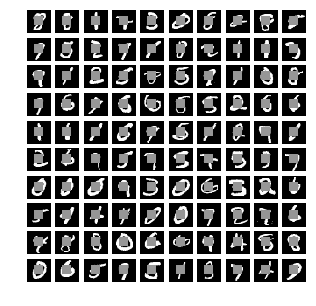

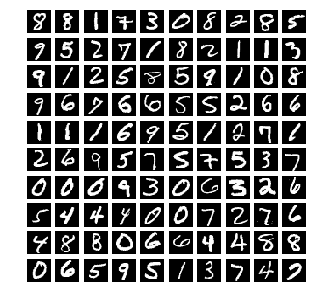

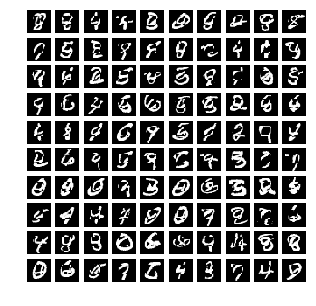

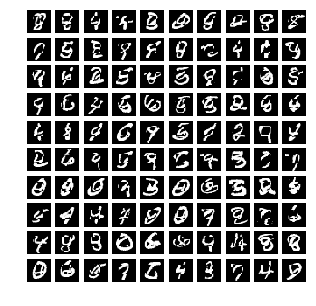

In [6]:
 
torch.save(G.state_dict(),'G.pt')

torch.save(D.state_dict(),'D.pt')
import matplotlib.pyplot as plt 
for i,data in enumerate(train_loader,0):
    img,lab=data
    print(img.shape)
    ok=img
    mask = torch.ones(size=image_shape)
    imageCenterScale = 0.3
    lm = int(28 * imageCenterScale)
    hm = int(28*(1 - imageCenterScale))
    mask[:,lm:hm, lm:hm] = 0.0
    img=torch.mul(img,mask)
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(5,5), sharey=True, sharex=True)
    print("Images For Appllying Inpainting")
    for ax, im in zip(axes.flatten(), img):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        ax.imshow(im.reshape((28,28)), cmap='Greys_r', aspect='equal')
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(5,5), sharey=True, sharex=True)
    
    print("Actual Images")
    for ax, im in zip(axes.flatten(), ok):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        ax.imshow(im.reshape((28,28)), cmap='Greys_r', aspect='equal')
    
    z_hat = torch.Tensor(100, 100).uniform_(-1, 1)
    z_hat.data.mul_(2.0).sub_(1.0)
    z_hat=Variable(z_hat.cuda())
    opt = optim.Adam([z_hat],lr=0.001)       
    v=torch.tensor(0,dtype=torch.float32)
    m=torch.tensor(0,dtype=torch.float32)
    img=Variable(img.cuda())
    criteria=nn.BCELoss()
    mask=Variable(mask.cuda())
    for iteration in range(200):
        if z_hat.grad is not None:
            z_hat.grad.data.zero_()
        G.zero_grad()
        D.zero_grad()
        batch_images_g = G(z_hat)
        batch_images_g=Variable(batch_images_g.cuda())
        batch_images_g_masked = torch.mul(batch_images_g,mask).cuda()
        
        impainting_images = torch.mul(batch_images_g,(1-mask))+img
        if iteration % 100==20:
            print("\n saving impainted images for batch: {} , iteration:{}".format(1,iteration))
            fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(5,5), sharey=True, sharex=True)
            
            for ax, im in zip(axes.flatten(), impainting_images):
                ax.axis('off')
                ax.set_adjustable('box-forced')
                ax.imshow(im.reshape((28,28)), cmap='Greys_r', aspect='equal')
    
            #save_tensor_images(impainting_images.detach(), os.path.join(impainted_imagedir,"impainted_image_batch_{}_iteration_{}.png".format(1,iteration)))

        loss_context = torch.norm(
            (img-batch_images_g_masked),p=1)
        dis_output = D(impainting_images)
#             print(dis_output)
        batch_labels = torch.full((100,), 1).cuda()
        loss_perceptual = criteria(dis_output,batch_labels)
            
        total_loss = loss_context + 0.01*loss_perceptual
        print("\r batch {} : iteration : {:4} , context_loss:{:.4f},percptual_loss:{:4f}".format(1,iteration,loss_context,loss_perceptual),end="")
        total_loss.backward()
        opt.step()    
    break
    